In [3]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr')

# Add the root directory of this repository
sys.path.append('../..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path, LinearRegression

from pyuoi.linear_model import UoI_Lasso

In [4]:
from misc import calc_avg_cov

In [5]:
# First thing is first, we need a way to characterize the design matrices that result from our choices of
# covariance matrices in terms of their condition number

In [6]:
n_features = 500

# Generate the covariance matrices used in our study
# Block sizes
block_sizes = [25, 50, 100]

# Block correlation
correlation = [0, 0.08891397, 0.15811388, 0.28117066, 0.5]

# Exponential length scales
L = [10, 25, 50, 100]

cov_list, _ = get_cov_list(n_features, 60, correlation, block_sizes, L, n_supplement = 20)

cov_params = [{'correlation' : t[0], 'block_size' : t[1], 'L' : t[2], 't': t[3]} for t in cov_list]

sigma = []

for params in cov_params:
    sigma.append(gen_covariance(n_features, **params))

In [17]:
# For each covariance matrix, sample 100 design matrices and calculate the average condition number 
# that results
n_reps = 100
n_samples = 4 * n_features
condition_numbers = np.zeros(len(sigma))
cnum_var = np.zeros(len(sigma))
for j, s in enumerate(sigma):
    cnums = np.zeros(n_reps)
    for i in range(n_reps):
        X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=s, size=n_samples)
        cnums[i] = np.linalg.cond(X)
    
    condition_numbers[j] = np.mean(cnums)
    cnum_var[j] = np.std(cnums)    
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [12]:
# Calculate the average covariance
avg_cov = np.zeros(len(sigma))
for j, s in enumerate(sigma):
    avg_cov[j] = np.mean(s)

In [24]:
# Calculate the rank of design matrices:
n_reps = 100
n_samples = 4 * n_features
ranks =np.zeros(len(sigma))
rank_var = np.zeros(len(sigma))
for j, s in enumerate(sigma):
    rs = np.zeros(n_reps)
    for i in range(n_reps):
        X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=s, size=n_samples)
        rs[i] = np.linalg.matrix_rank(X)
    
    ranks[j] = np.mean(rs)
    rank_var[j] = np.std(rs)    
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


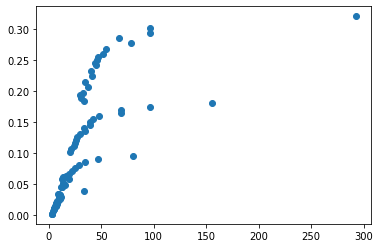

In [15]:
plt.plot(condition_numbers, avg_cov, 'o')

In [42]:
def validate_irrepresentible(X, support):
    # Validate whether the design matrix satisfies the irrepresentible condition, assuming that the
    # sign of all coefficients are positive
    
    n, p = X.shape
    q = np.count_nonzero(support)
    
    # Restrict the data to the support and the component lacking the support
    X1 = X[:, support]
    X2 = X[:, np.invert(support)]
    
    # calculate the quadrants of the grammian
    C11 = 1/n * X1.T @ X1
    C12 = 1/n * X1.T @ X2
    C21 = 1/n * X2.T @ X1
    C22 = 1/n * X2.T @ X2
        
    if np.any([0 in C11.shape, 0 in C12.shape, 0 in C21.shape, 0 in C22.shape]):
        return np.nan
    else:
        # Inequality needs to hold element-wise
        return np.all(np.sum(np.abs(C21 @ np.linalg.inv(C11)), axis= 1) < np.ones(p - q))

In [43]:
# Also relevant here: Sparsity and block structure

sparsity = np.logspace(np.log10(0.02), 0, 15)
block_size = [20, 50, 100, 500]
n_reps = 10
irrepresentible = np.zeros((len(sigma), n_reps, sparsity.size, len(block_size)))
for i1, s in enumerate(sigma):    
    t0 = time.time()
    for j in range(n_reps):
        X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=s, size=n_samples)
        for i2, spar in enumerate(sparsity):
            for i3, bs in enumerate(block_size):
                beta = gen_beta2(n_features = n_features, block_size = bs, sparsity = spar)
                support = beta.astype(bool).ravel()
                irrepresentible[i1, j, i2, i3] = validate_irrepresentible(X, support)
        print('(i1, j) = (%d, %d), Time = %f' % (i1, j, time.time() - t0))

(i1, j) = (0, 0), Time = 0.796822
(i1, j) = (0, 1), Time = 1.609585
(i1, j) = (0, 2), Time = 2.419962
(i1, j) = (0, 3), Time = 3.210944
(i1, j) = (0, 4), Time = 3.996909
(i1, j) = (0, 5), Time = 4.788647
(i1, j) = (0, 6), Time = 5.601683
(i1, j) = (0, 7), Time = 6.393970
(i1, j) = (0, 8), Time = 7.190287
(i1, j) = (0, 9), Time = 7.983476
(i1, j) = (1, 0), Time = 0.790568
(i1, j) = (1, 1), Time = 1.596100
(i1, j) = (1, 2), Time = 2.395591
(i1, j) = (1, 3), Time = 3.197082
(i1, j) = (1, 4), Time = 3.995264
(i1, j) = (1, 5), Time = 4.819543
(i1, j) = (1, 6), Time = 5.620553
(i1, j) = (1, 7), Time = 6.415505
(i1, j) = (1, 8), Time = 7.210755
(i1, j) = (1, 9), Time = 8.001942
(i1, j) = (2, 0), Time = 0.788781
(i1, j) = (2, 1), Time = 1.578781
(i1, j) = (2, 2), Time = 2.367256
(i1, j) = (2, 3), Time = 3.167217
(i1, j) = (2, 4), Time = 3.991885
(i1, j) = (2, 5), Time = 4.790977
(i1, j) = (2, 6), Time = 5.603155
(i1, j) = (2, 7), Time = 6.405863
(i1, j) = (2, 8), Time = 7.219051
(i1, j) = (2, 

(i1, j) = (23, 7), Time = 6.398777
(i1, j) = (23, 8), Time = 7.194405
(i1, j) = (23, 9), Time = 8.002042
(i1, j) = (24, 0), Time = 0.791408
(i1, j) = (24, 1), Time = 1.667880
(i1, j) = (24, 2), Time = 2.463197
(i1, j) = (24, 3), Time = 3.256642
(i1, j) = (24, 4), Time = 4.048617
(i1, j) = (24, 5), Time = 4.839769
(i1, j) = (24, 6), Time = 5.637602
(i1, j) = (24, 7), Time = 6.430676
(i1, j) = (24, 8), Time = 7.224763
(i1, j) = (24, 9), Time = 8.025796
(i1, j) = (25, 0), Time = 0.800910
(i1, j) = (25, 1), Time = 1.596976
(i1, j) = (25, 2), Time = 2.378650
(i1, j) = (25, 3), Time = 3.174219
(i1, j) = (25, 4), Time = 3.959209
(i1, j) = (25, 5), Time = 4.804660
(i1, j) = (25, 6), Time = 5.597590
(i1, j) = (25, 7), Time = 6.397180
(i1, j) = (25, 8), Time = 7.192549
(i1, j) = (25, 9), Time = 7.980350
(i1, j) = (26, 0), Time = 0.785128
(i1, j) = (26, 1), Time = 1.570177
(i1, j) = (26, 2), Time = 2.358846
(i1, j) = (26, 3), Time = 3.148556
(i1, j) = (26, 4), Time = 3.932131
(i1, j) = (26, 5), T

(i1, j) = (47, 2), Time = 2.365391
(i1, j) = (47, 3), Time = 3.139483
(i1, j) = (47, 4), Time = 4.019018
(i1, j) = (47, 5), Time = 4.835719
(i1, j) = (47, 6), Time = 5.615731
(i1, j) = (47, 7), Time = 6.383672
(i1, j) = (47, 8), Time = 7.163700
(i1, j) = (47, 9), Time = 7.946086
(i1, j) = (48, 0), Time = 0.782755
(i1, j) = (48, 1), Time = 1.588259
(i1, j) = (48, 2), Time = 2.359472
(i1, j) = (48, 3), Time = 3.138883
(i1, j) = (48, 4), Time = 3.919331
(i1, j) = (48, 5), Time = 4.698872
(i1, j) = (48, 6), Time = 5.474262
(i1, j) = (48, 7), Time = 6.255228
(i1, j) = (48, 8), Time = 7.050297
(i1, j) = (48, 9), Time = 7.825365
(i1, j) = (49, 0), Time = 0.790998
(i1, j) = (49, 1), Time = 1.557388
(i1, j) = (49, 2), Time = 2.336880
(i1, j) = (49, 3), Time = 3.110757
(i1, j) = (49, 4), Time = 3.916946
(i1, j) = (49, 5), Time = 4.682602
(i1, j) = (49, 6), Time = 5.453982
(i1, j) = (49, 7), Time = 6.229626
(i1, j) = (49, 8), Time = 7.169168
(i1, j) = (49, 9), Time = 7.940408
(i1, j) = (50, 0), T

(i1, j) = (70, 7), Time = 6.353577
(i1, j) = (70, 8), Time = 7.124380
(i1, j) = (70, 9), Time = 7.894867
(i1, j) = (71, 0), Time = 0.776348
(i1, j) = (71, 1), Time = 1.548741
(i1, j) = (71, 2), Time = 2.317081
(i1, j) = (71, 3), Time = 3.083560
(i1, j) = (71, 4), Time = 3.850571
(i1, j) = (71, 5), Time = 4.625316
(i1, j) = (71, 6), Time = 5.403995
(i1, j) = (71, 7), Time = 6.183446
(i1, j) = (71, 8), Time = 6.960423
(i1, j) = (71, 9), Time = 7.726804
(i1, j) = (72, 0), Time = 0.776985
(i1, j) = (72, 1), Time = 1.599015
(i1, j) = (72, 2), Time = 2.371047
(i1, j) = (72, 3), Time = 3.141770
(i1, j) = (72, 4), Time = 3.927276
(i1, j) = (72, 5), Time = 4.708839
(i1, j) = (72, 6), Time = 5.492172
(i1, j) = (72, 7), Time = 6.266940
(i1, j) = (72, 8), Time = 7.038697
(i1, j) = (72, 9), Time = 7.812592
(i1, j) = (73, 0), Time = 0.764791
(i1, j) = (73, 1), Time = 1.539194
(i1, j) = (73, 2), Time = 2.309714
(i1, j) = (73, 3), Time = 3.086984
(i1, j) = (73, 4), Time = 3.864606
(i1, j) = (73, 5), T

In [50]:
# Need to save away the data above, preserving labels of covariance params, sparsity, block size.
import pickle

In [52]:
# First, the condition numbers:
with open('cond_nums.dat', 'wb') as f:
    f.write(pickle.dumps(cov_params))
    f.write(pickle.dumps(condition_numbers))
    f.write(pickle.dumps(cnum_var))

In [53]:
# Next, the verification of the irrepresentable condition
with open('irrep_cond.dat', 'wb') as f:
    f.write(pickle.dumps('(cov_params, reps, sparsity, block_size)'))
    f.write(pickle.dumps({'cov_params': cov_params, 'sparsity': sparsity, 'block_size': block_size}))
    f.write(pickle.dumps(irrepresentible))

In [44]:
np.count_nonzero(1 * (irrepresentible.ravel() == 1))

4213

In [49]:
np.count_nonzero(1 * np.isnan(irrepresentible.ravel()))

6400

In [48]:
irrepresentible.ravel().size

48000

In [ ]:
# Do our covariance matrices violate the various properties necessary for Lasso consistency? What about 
# SCAD/MCP? 

# Restricted Isometry 
# Restricted Eigenvalue
# Compatibility
# Irrespresentible

# Plot average covariance vs. condition number
# Plot average covariance vs. smallest eigenvalue of gram matrix
# Plot average covariance vs. smallest eigenvalue of gram matrix, restricted to the active set
# Plot average covariance vs. deviance from the irrepresentible condition

# For SCAD, we just need to show that the fisher information matrix is full rank (see Sleppian-Bangs formula)

# For MCP

# Don't forget the locally linear approximation algorithm

In [ ]:
# SCAD consistency: Calculate the rank of the Fisher information matrix

In [13]:
def validate_scad_consistency(X, support):
    
    N, p = X.shape     
    k = np.count_noznero(1 * support)
    X = X[:, support]
        
    # restrict the basis of the FIM to the non-zero components of the regression 
    # vector

    FIM = np.zeros((k, k))
    
    for i in range(p):
        for j in range(p):
    
            # If either feature is not in the support, keep the entry zero
            if not support[i] or not support[j]:
                continue
            else:
                # We have dropped the N and sigma^2 because it will not affect the positive definite property
                FIM[i, j] = X[:, i].T @ X[:, j].T
    
    # The FIM must be positive definite
    return np.all(np.linalg.eigvals(FIM) > 0)

In [14]:
n_features = 500
n_samples = 2000

sparsity = np.logspace(np.log10(0.02), 0, 15)
block_size = [20, 50, 100, 500]
n_reps = 5
posdef = np.zeros((len(sigma), n_reps, sparsity.size, len(block_size)))

for i1, s in enumerate(sigma):    
    t0 = time.time()
    for j in range(n_reps):
        X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=s, size=n_samples)
        for i2, spar in enumerate(sparsity):
            for i3, bs in enumerate(block_size):
                beta = gen_beta2(n_features = n_features, block_size = bs, sparsity = spar)
                support = beta.astype(bool).ravel()
                posdef[i1, j, i2, i3] = validate_scad_consistency(X, support)
        print('(i1, j) = (%d, %d), Time = %f' % (i1, j, time.time() - t0))

> <ipython-input-13-95ed35120d6c>(18)validate_scad_consistency()
-> return np.all(np.linalg.eigvals(FIM) > 0)
(Pdb) eigvals = np.linalg.eigvals(FIM)
(Pdb) eigvals
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0

(Pdb) quit()


BdbQuit: 

In [ ]:
# Full rank FIM on the true coefficient space reduces to the condition that C11 (in irrepresntible condition
# parlance is full rank). This holds for essentially all design matrices without duplicate measurements